# Documentation

This notebook is best run in Google Colab to leverage the free GPU.

If notebook is run in Google Colab:
1.   Modify the file path for data import
2. Run the notebook (advised to change to GPU runtime)

If notebook is run on local system:

1.   Run `pip install -r requirements.txt` to install required packages
2.   Modify file path for data import
3. Run the notebook

# Setup

All the following libraries are available in Google Colab. If you are using local Jupyter Notebook, please run `pip install requirements.txt` before running the notebook.

In [1]:
# General libraries
import random
import pandas as pd        
import numpy as np
import time
import copy
import warnings
warnings.filterwarnings("ignore")

# Plotting libraries
import matplotlib.pyplot as plt   

# Deep learning libraries
from keras.layers import Input, Dense, LeakyReLU, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import cv2 # OpenCV

# Import data

In [3]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
root_path = '/content/gdrive/My Drive/data/'
train_path = '/content/gdrive/My Drive/train_images/train_images/' # Contains training images
test_path = '/content/gdrive/My Drive/test_images/test_images/' # Contains test images

train_csv = pd.read_csv(root_path+"train.csv") # Contains label of training data (anomaly vs non anomaly)
df = copy.deepcopy(train_csv) # Make a copy and rename variable

# Data Preprocessing

We loop through each of the training images and convert it into a numpy array using OpenCV. At this stage, the labels from train.csv is also combined.

This section will take some time to run (40 minutes).

It is suggested that after the first round the images were read, save `df` into a csv so that you do not have to keep using OpenCV to read the images.


## For training data (labelled)

In [5]:
%%time
temp_arr = []

for idx in range(len(df)): # loop through training data
    label = df.iloc[idx,1] # obtain the label
    idx_label_image = [label] # create a list to house the label

    img_arr = cv2.imread(train_path + str(idx) +".jpg", 0).flatten() # read a grayscale image with OpenCV

    idx_label_image.extend(list(img_arr)) # append array into existing list
    temp_arr.append(idx_label_image) # append this training row into temp array

CPU times: user 3.94 s, sys: 2.88 s, total: 6.82 s
Wall time: 40min 24s


In [6]:
df = pd.DataFrame(temp_arr)
df = df.rename(columns={0: "label"}) # Rename first column to 'label'
df

,label,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783,784
0,1,0,0,0,0,0,0,0,0,1,0,2,5,0,10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,9,0,5,20,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,1,13,2,0,1,4,0,1,8,0,0,7,0,0,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,1,2,9,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,6,12,0,4,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,9,0,0,11,0,7,0,0,3,0,0,11,6,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,12,0,0,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,2,3,3,1,0,0,1,6,0,3,0,1,4,0,3,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6422,0,0,0,0,0,0,0,0,0,4,1,0,0,10,0,11,0,0,0,4,0,8,0,8,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6423,0,0,0,0,0,0,0,0,0,0,0,4,0,7,0,10,0,10,0,0,12,1,0,9,0,0,0,0,0,0,0,0,0,0,0,0,0,11,2,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6424,0,0,0,0,0,0,0,0,0,0,9,6,0,0,0,0,5,3,5,2,0,0,3,2,0,0,0,0,0,0,0,0,0,0,0,0,0,7,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6425,0,6,0,1,0,6,0,12,0,1,1,1,1,1,1,1,1,4,0,5,0,2,0,0,1,0,0,0,0,0,0,12,3,3,3,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [7]:
# # It is suggested that after the first round you read the images, save it into a csv so that you do not have to keep using OpenCV to read the images.
# df.to_csv(index=False)
# df = pd.read_csv(root_path+'df.csv').iloc[:, 1:]

## For test data (unlabelled), for submission

In [8]:
%%time
temp_arr_pred = []

for idx in range(1070): # 1070 images to predict
    temp_arr_pred.append(cv2.imread(test_path + str(idx) +".jpg", 0).flatten()) # read a grayscale image with OpenCV

CPU times: user 401 ms, sys: 406 ms, total: 807 ms
Wall time: 6min 22s


In [9]:
df_pred = pd.DataFrame(temp_arr_pred)
df_pred

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783
0,0,0,0,0,0,0,0,0,6,0,4,1,0,8,0,0,0,0,3,0,10,0,6,1,0,0,0,0,0,0,0,0,0,0,0,0,5,0,8,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,1,1,0,0,0,1,7,0,0,6,2,0,0,10,0,10,0,10,0,0,9,0,0,0,0,0,1,1,1,0,0,0,0,0,0,4,5,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,4,6,0,0,0,8,0,6,0,0,0,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7,7,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,1,0,2,5,3,0,0,4,2,0,8,0,6,1,2,1,0,0,0,0,0,0,0,0,0,0,0,0,6,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,3,0,4,0,0,0,3,6,2,0,4,11,0,6,0,3,0,0,0,0,0,0,0,0,0,0,0,0,10,0,15,4,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1065,0,0,0,0,0,0,0,0,0,2,3,0,0,7,6,0,0,7,0,8,0,5,0,12,0,0,0,0,0,0,0,0,0,0,0,0,0,4,5,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1066,0,3,6,1,0,2,2,0,13,0,6,0,1,7,0,0,11,0,7,5,0,0,1,5,0,0,0,0,0,4,3,0,0,0,0,0,0,0,16,6,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1067,0,0,0,0,0,0,0,0,0,3,7,0,6,0,0,9,0,4,0,9,11,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,15,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1068,0,0,0,0,0,0,0,0,5,0,15,0,0,1,0,4,0,0,6,0,0,2,12,0,0,0,0,0,0,0,0,0,0,0,0,0,2,6,3,21,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [10]:
# # It is suggested that after the first round you read the images, save it into a csv so that you do not have to keep using OpenCV to read the images.
# df_pred.to_csv(index=False)
# # Load original data to be predicted
# df_pred = pd.read_csv(root_path+'df_pred.csv')

## Train test split



1.   Training dataset must only contain non-anomalies (0)
2.   Testing dataset contains a mix of non-anomalies and anomalies (0,1,2,...,9)
3. Train-test ratio is 90:10
4. Seed is set to 4012 for replicability









In [11]:
random.seed(4012)

normal = df[df.label == 0] # Select all the non-anomalies
anomalies = df[df.label == 1] # Select all the anomalies

normal = normal.sample(frac=1) # shuffle data
cutoff = int(len(normal)*(90/100)) # split 90% train, 10% test
df_train = normal[:cutoff].reset_index().drop(columns="index") # Training data should only contain non-anomalies
df_test = pd.concat([normal[cutoff:],anomalies]).sample(frac=1).reset_index().drop(columns="index") # Test data should contain both anomalies and non-anomalies

In [12]:
print("Number of normal images in total:", len(normal))
print("Number of anomaly images in total:", len(anomalies))
print("Number of normal images in train:", cutoff)
print("Number of anomaly images in train:", 0)
print("Number of normal images in test:", len(normal)-cutoff)
print("Number of anomaly images in test:", len(anomalies))

Number of normal images in total: 5923
Number of anomaly images in total: 504
Number of normal images in train: 5330
Number of anomaly images in train: 0
Number of normal images in test: 593
Number of anomaly images in test: 504


## Image augmentation

Purpose: allow machine to better learn different forms of image and to increase number of datapoints

### Augment normal data

In [13]:
# Reference: https://machinelearningmastery.com/image-augmentation-deep-learning-keras/

# load data
df_aug = np.array(normal.drop(columns="label")) # augmenting the normal data
X_train = df_aug
X_train = X_train.reshape((X_train.shape[0], 28, 28, 1))
X_train = X_train.astype('float32')

X_train_augmented = [] # store augmented images

def rotate_images():
    # define data preparation
    datagen = ImageDataGenerator(rotation_range=90)
    count = 0

    # fit parameters from data
    datagen.fit(X_train)

    # Generate images
    for X_batch in datagen.flow(X_train, batch_size=3):
        for i in range(0, 3):
            if count >= len(df_aug):
                return
            else:
                count += 1
                X_train_augmented.append(X_batch[i].flatten())
            

def shift_images():
    # define data preparation
    shift = 0.2
    datagen = ImageDataGenerator(width_shift_range=shift, height_shift_range=shift)
    count = 0

    # fit parameters from data
    datagen.fit(X_train)

    # Generate images
    for X_batch in datagen.flow(X_train, batch_size=3):
        for i in range(0, 3):
            if count >= len(df_aug):
                return
            else:
                count += 1
                X_train_augmented.append(X_batch[i].flatten())

def flip_images():
    # define data preparation
    datagen = ImageDataGenerator(horizontal_flip=True, vertical_flip=True)
    count = 0
    # fit parameters from data
    datagen.fit(X_train)

    # Generate images
    for X_batch in datagen.flow(X_train, batch_size=3):
        for i in range(0, 3):
            if count >= len(df_aug):
                return
            else:
                count += 1
                X_train_augmented.append(X_batch[i].flatten())

rotate_images()
shift_images()
flip_images()

In [14]:
lbls = [0]*len(X_train_augmented) # Labels for augmented image are all 0 since we only augmented non-anomalies
df_train_augmented = pd.DataFrame(X_train_augmented)
df_train_augmented.insert(0, "label", lbls)
df_train_augmented

,label,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,...,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783
0,0,3.736786,1.651712,0.641660,0.120391,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.533695,0.23064,3.293317,5.781876,2.188389,0.000000,0.000000,0.781788,3.804641,0.39107,0.000000,0.000000,5.537589,5.016321,2.980210,0.973784,0.452516,0.000000,0.171402,0.000000,0.000000,0.000000,0.000000,...,1.370537,4.348796,4.159118,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.808409,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,4.675043,10.820611,5.033821,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.87421,0.362071,0.262450,1.921205,1.210019,0.380641,0.000000,0.000000,0.00000,0.000000,10.727473,0.000000,1.697454,7.843022,8.011410,1.865842,0.000000,0.000000,1.091816,0.000000,0.000000,0.000000,...,0.135214,0.643021,0.014201,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.234543,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,0.000000,0.000000,1.870524,4.900379,2.297178,2.632529,5.886531,5.371893,3.142967,0.039531,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.00000,6.806141,4.979338,5.325152,0.010410,0.000000,7.238150,10.132365,0.00000,0.000000,3.878044,4.120469,0.215666,0.000000,1.328282,4.582283,2.730972,2.090287,5.265949,1.584955,4.912205,1.381075,...,0.000000,0.046556,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,3.030340,0.550322,0.000000,0.000000,0.067662,3.490645,1.814778,0.415847,0.000000,0.886935,4.059735,7.166361,1.147386,2.978306,3.545405,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.020851,1.57304,2.874771,1.322582,5.617322,1.338593,0.211973,0.000000,0.000000,1.421060,3.366967,0.933243,0.077497,1.119257,3.217100,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.206887,0.777073,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.670572,3.008599,1.326023,2.669823,1.334332,0.000000,0.000000,4.643107,2.364163,0.000000,0.0,0.000000,0.00000,0.657069,1.000000,1.000000,0.346047,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.261786,1.072045,0.494298,0.701880,2.728631,4.546292,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17764,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,11.000000,0.000000,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,4.0,0.0,0.0,11.0,0.000000,6.000000,4.0,0.0,1.0,2.0,0.000000,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17765,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,4.000000,0.000000,0.000000,11.00000

In [15]:
normal = copy.deepcopy(df_train_augmented)

### Augment anomalies

In [16]:
# Reference: https://machinelearningmastery.com/image-augmentation-deep-learning-keras/

# load data
df_aug = np.array(anomalies.drop(columns="label")) # augmenting the anomalies
X_train = df_aug
X_train = X_train.reshape((X_train.shape[0], 28, 28, 1))
X_train = X_train.astype('float32')

X_train_augmented = [] # store augmented images

def rotate_images():
    # define data preparation
    datagen = ImageDataGenerator(rotation_range=90) 
    count = 0

    # fit parameters from data
    datagen.fit(X_train)

    # Generate images
    for X_batch in datagen.flow(X_train, batch_size=3):
        for i in range(0, 3):
            if count >= len(df_aug):
                return
            else:
                count += 1
                X_train_augmented.append(X_batch[i].flatten())

def shift_images():
    # define data preparation
    shift = 0.2
    datagen = ImageDataGenerator(width_shift_range=shift, height_shift_range=shift)
    count = 0

    # fit parameters from data
    datagen.fit(X_train)

    # Generate images
    for X_batch in datagen.flow(X_train, batch_size=3):
        for i in range(0, 3):
            if count >= len(df_aug):
                return
            else:
                count += 1
                X_train_augmented.append(X_batch[i].flatten())

def flip_images():
    # define data preparation
    datagen = ImageDataGenerator(horizontal_flip=True, vertical_flip=True)
    count = 0

    # fit parameters from data
    datagen.fit(X_train)

    # Generate images
    for X_batch in datagen.flow(X_train, batch_size=3):
        for i in range(0, 3):
            if count >= len(df_aug):
                return
            else:
                count += 1
                X_train_augmented.append(X_batch[i].flatten())

rotate_images()
shift_images()
flip_images()

In [17]:
lbls = [1]*len(X_train_augmented) # Labels for augmented image are all 1 since we only augmented anomalies
df_train_augmented = pd.DataFrame(X_train_augmented)
df_train_augmented.insert(0, "label", lbls)
df_train_augmented

,label,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,...,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783
0,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,4.575473,0.028766,0.000000,0.000000,0.000000,0.00000,0.000000,0.0,0.0,0.0,0.0,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,10.565461,8.390462,0.114916,0.875252,0.364411,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
1,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.0,0.0,0.0,0.0,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,5.312867,0.998080,0.000000,0.472554,4.966228,5.276352,3.837152,5.474096,1.208020,13.913206,3.222915,4.552726,5.992708,2.787808,0.032567,0.011377,0.000000,0.000000,0.00000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
2,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.33181,3.228667,0.789145,4.951133,11.730299,4.411731,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.0,0.0,0.0,0.0,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
3,1,0.897038,0.626732,0.522277,2.629711,7.101475,2.907912,0.354939,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,2.997758,0.101552,0.952543,0.196466,5.236199,5.47242,1.930479,0.0,0.0,0.0,0.0,...,8.86938,4.260543,5.252949,2.010441,4.367276,30.747999,4.871276,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.127643,0.000000,0.206004,0.517599,9.93905,2.588205,0.0,14.467417,21.151859,0.0,0.0,0.0,0.0,0.0
4,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.0,0.0,0.0,0.0,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.846532,0.000000,0.000000,1.355434,2.702700,1.714424,0.023448,6.670115,1.384511,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1507,1,2.000000,3.000000,6.000000,0.000000,6.000000,0.000000,0.000000,12.0,2.0,0.0,1.0,0.0,0.0,1.0,5.0,0.0,2.0,0.0,0.0,5.0,3.0,0.0,0.00000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,7.000000,4.000000,7.00000,12.000000,0.0,4.0,0.0,0.0,...,10.00000,13.000000,8.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,5.000000,4.000000,1.000000,5.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.0,3.000000,6.000000,4.0,0.0,0.

In [18]:
anomalies = copy.deepcopy(df_train_augmented)

In [19]:
random.seed(4012)

normal = normal.sample(frac=1) # shuffle data
cutoff = int(len(normal)*(90/100)) # split 90% train, 10% test
df_train_augmented = normal[:cutoff].reset_index().drop(columns="index") # Training data should only contain non-anomalies
df_test_augmented = pd.concat([normal[cutoff:],anomalies]).sample(frac=1).reset_index().drop(columns="index") # Test data should contain both anomalies and non-anomalies

In [20]:
print("Number of normal images in total:", len(normal))
print("Number of anomaly images in total:", len(anomalies))
print("Number of normal images in train:", cutoff)
print("Number of anomaly images in train:", 0)
print("Number of normal images in test:", len(normal)-cutoff)
print("Number of anomaly images in test:", len(anomalies))

Number of normal images in total: 17769
Number of anomaly images in total: 1512
Number of normal images in train: 15992
Number of anomaly images in train: 0
Number of normal images in test: 1777
Number of anomaly images in test: 1512


# MODEL 1: Simple Autoencoder

1. This section builds a simple 1 hidden layer autoencoder.
2. Gridsearch is performed to find the optimal hyperparameters.
3. After the optimal hyperparameters are found, we plot the loss distribution to determine our threshold for anomaly.
4. Lastly, a confusion matrix is plotted before test data are used to generate predictions for submission at Kaggle.



## Model Training Methods

In [21]:
def train_model(encoding_dim, loss, optimizer, augmented, epoch):
    '''
    This function trains our model. Primarily used for GridSearch to find the best model

    Input:
        1. Encoding dimension
        2. Loss function
        3. Optimizer
        4. Augmented (True specified to use augmented data, False specifies to use normal data)
        5. Number of epochs
    Output:
        1. Training history of model
        2. The trained autoencoder model
    '''

    '''
    Build autoencoder model
    '''

    # Start building model sequentially
    input_img = Input(shape=(784,)) # Input later

    encoded = Dense(encoding_dim)(input_img) # Encoder layer
    encoded = LeakyReLU()(encoded) # LeakyReLu activation to prevent dying nodes

    decoded = Dense(encoding_dim)(encoded) # Decoder layer
    decoded = LeakyReLU()(decoded) # LeakyReLu activation to prevent dying nodes

    decoded = Dense(784, activation='sigmoid')(decoded) # Ouput layer with sigmoid function


    # Maps input to encoded representation
    encoder = Model(input_img, encoded)
    # Maps input to decoded representation
    autoencoder = Model(input_img, decoded)

    autoencoder.compile(loss=loss, optimizer = optimizer)

    '''
    Prepare input data
    '''
    if augmented:
        x_train = copy.deepcopy(df_train_augmented).iloc[:,1:]
    else:
        x_train = copy.deepcopy(df_train).iloc[:,1:]

    x_train = np.array(x_train) # Convert to array
    x_train = x_train.astype('float32') / 255. # Normalize
    x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:]))) # Reshape


    '''
    Start model training
    '''
    history = autoencoder.fit(x_train, x_train,
                epochs=epoch,
                batch_size=128,
                shuffle=True,
                validation_split=0.2, # split 20% validation
                verbose=0)
    
    return history, autoencoder

## Model Validation Methods

In [22]:
def plot_train_test_val(history):
    '''
    This function generates a plot of the training and validation losses during training
    Input:
        1. History of model
    Output:
        1. Plot of training and validation losses per epoch
    '''
    plt.plot(history.history['loss'], label='Training loss')
    plt.plot(history.history['val_loss'], label='Validation loss')
    plt.title('Losses')
    plt.ylabel('Loss value')
    plt.xlabel('No. epoch')
    plt.legend(loc="upper right")
    plt.show()

In [23]:
def generate_prediction(loss, augmented):
    '''
    This function calculates the losses from test data and generate predicted images
    Input:
        1. Loss function
        2. Augmented (True specified to use augmented data, False specifies to use normal data)
    Output:
        1. Array of losses
        2. Array of original test images
        3. Array of images predicted by autoencoder
    '''

    '''
    Generate decoded images with test data
    '''
    if augmented:
        x_pred = copy.deepcopy(df_test_augmented).iloc[:,1:] # Copy testing data
    else:
        x_pred = copy.deepcopy(df_test).iloc[:,1:] # Copy testing data
    x_pred_arr = np.array(x_pred) # Convert to array
    x_pred_arr = x_pred_arr.astype('float32') / 255. # Normalize
    x_pred_arr = x_pred_arr.reshape((len(x_pred_arr), np.prod(x_pred_arr.shape[1:]))) # Reshape

    decoded_imgs = autoencoder.predict(x_pred_arr)
    
    '''
    Calculate losses and append into a list
    '''
    if loss == 'mean_absolute_error':
        mae = tf.keras.losses.MeanAbsoluteError()
        loss_dist = []
        for i in range(len(x_pred_arr)):
            loss_dist.append(mae(x_pred_arr[i], decoded_imgs[i]).numpy())
    elif loss == 'mean_squared_error':
        mse = tf.keras.losses.MeanSquaredError()
        loss_dist = []
        for i in range(len(x_pred_arr)):
            loss_dist.append(mse(x_pred_arr[i], decoded_imgs[i]).numpy())
    else: # BCE
        bce = tf.keras.losses.BinaryCrossentropy()
        loss_dist = []
        for i in range(len(x_pred_arr)):
            loss_dist.append(bce(x_pred_arr[i], decoded_imgs[i]).numpy())

    return loss_dist, x_pred_arr, decoded_imgs

In [24]:
def plot_losses(threshold, losses):
    '''
    This function plots a distribution of losses with the provided threshold labelled
    Input:
        1. Threshold
        2. Loss distribution array
    Output:
        1. Plot of loss distribution
    '''

    plt.figure(figsize=(10,6))
    plt.title('Loss Distribution')
    sns.distplot(losses,bins=100,kde=True, color='blue')
    plt.axvline(threshold, 0.0, 10, color='r')
    plt.show()

In [25]:
def plot_cm(threshold, loss_dist, augmented):
    '''
    This function plots a confusion matrix
    Input:
        1. Threshold to be considered an anomaly
        2. Loss distribution
        3. Augmented (True specified to use augmented data, False specifies to use normal data)

    Output:
        1. Plot of confusion matrix
    '''

    '''
    Generate data for CM
    '''
    if augmented:
        df = df_test_augmented
    else:
        df = df_test
    ddf = pd.DataFrame(columns=df.columns)
    tp = 0
    fp = 0
    tn = 0
    fn = 0
    # total_anom = 0
    for i in range(len(loss_dist)):
        if loss_dist[i] >= threshold: # Above threshold, means anomaly
            if float(df.iloc[i]['label']) == 1.0: # If label is anomaly and model is anomaly
                tp += 1
            else: # If label is not anomaly and model is anomaly
                fp += 1
        else: # Below threshold, means normal data
            if float(df.iloc[i]['label']) == 1.0: # If label is anomaly and model is not anomaly
                fn += 1
            else: # If label is not anomaly and model is not anomaly
                tn += 1

    '''
    Plot CM
    '''
    conf = [[tn,fp],[fn,tp]]
    plt.figure()
    sns.heatmap(conf,annot=True,annot_kws={"size": 16},fmt='g')

## Gridsearch

A total of 54 models are created and the loss distribution is plotted.

We aim to obtain a loss distribution with 2 distinct peaks that are separated at a threshold.

Model: 0 ,encoding_dim: 32 ,loss_fn: mean_absolute_error ,optimizer: adam ,augmented: True


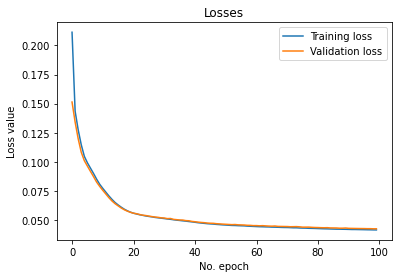

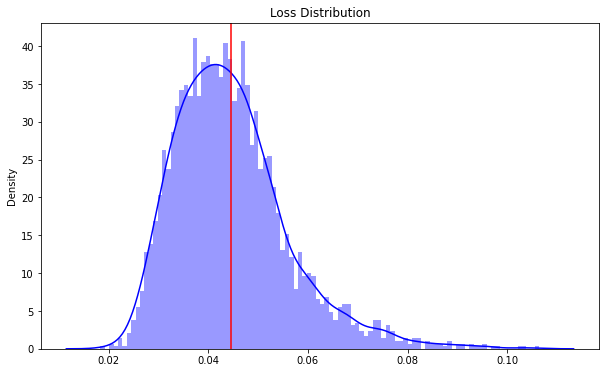

Model: 1 ,encoding_dim: 32 ,loss_fn: mean_absolute_error ,optimizer: adam ,augmented: False


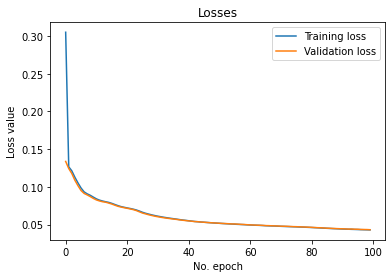

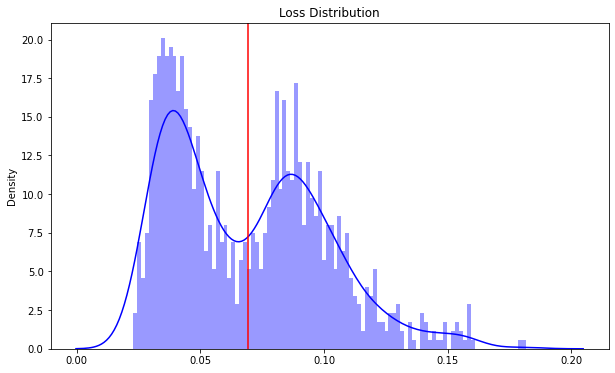

Model: 2 ,encoding_dim: 32 ,loss_fn: mean_absolute_error ,optimizer: RMSprop ,augmented: True


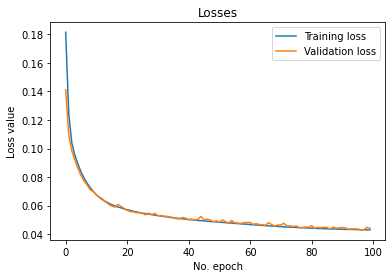

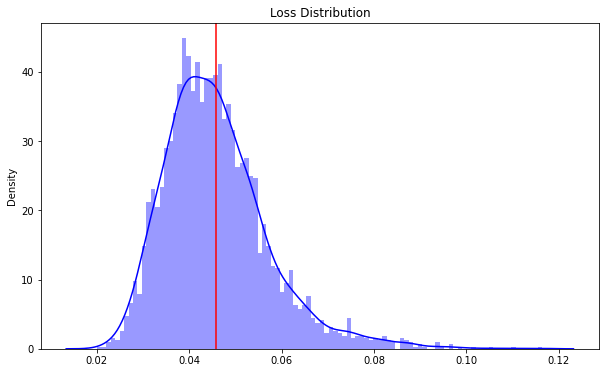

Model: 3 ,encoding_dim: 32 ,loss_fn: mean_absolute_error ,optimizer: RMSprop ,augmented: False


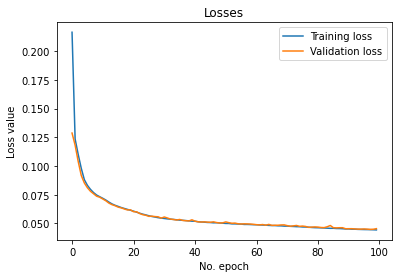

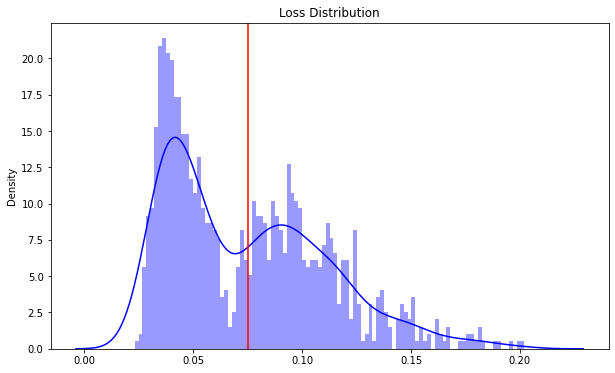

Model: 4 ,encoding_dim: 32 ,loss_fn: mean_absolute_error ,optimizer: adadelta ,augmented: True


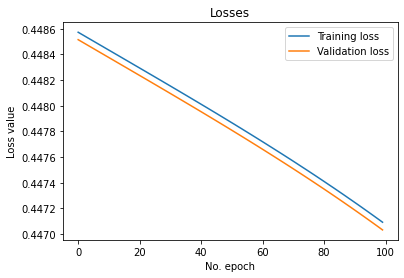

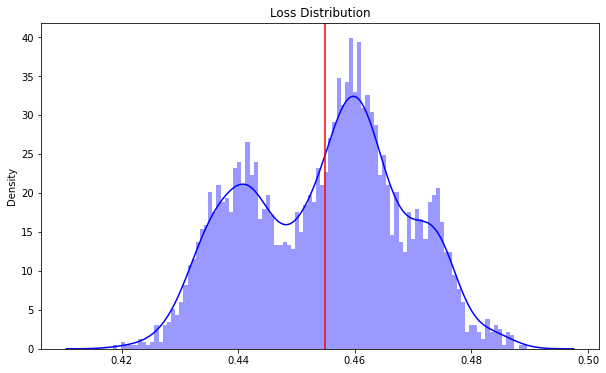

Model: 5 ,encoding_dim: 32 ,loss_fn: mean_absolute_error ,optimizer: adadelta ,augmented: False


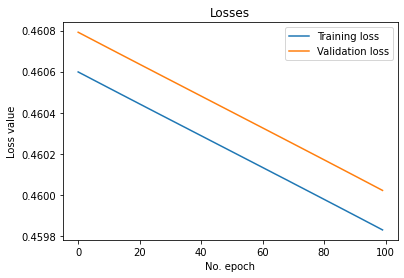

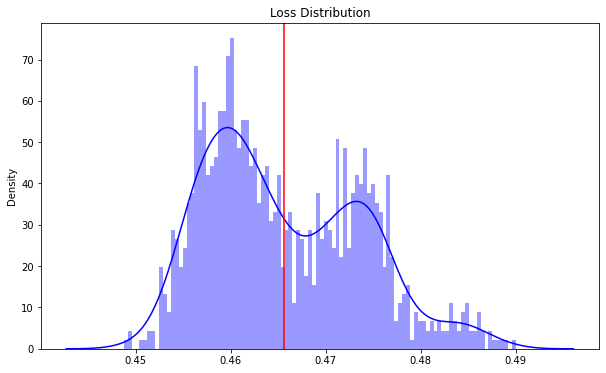

Model: 6 ,encoding_dim: 32 ,loss_fn: mean_squared_error ,optimizer: adam ,augmented: True


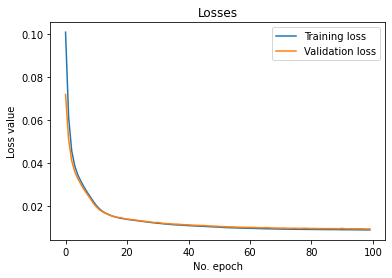

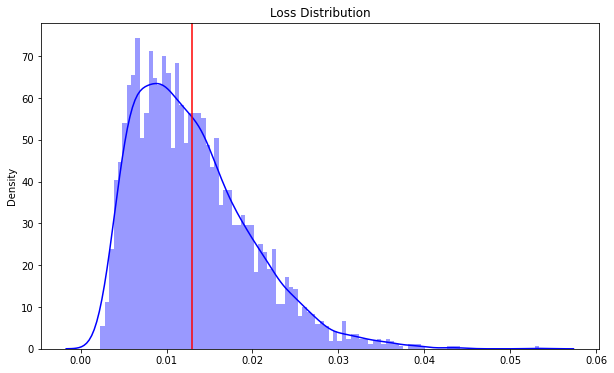

Model: 7 ,encoding_dim: 32 ,loss_fn: mean_squared_error ,optimizer: adam ,augmented: False


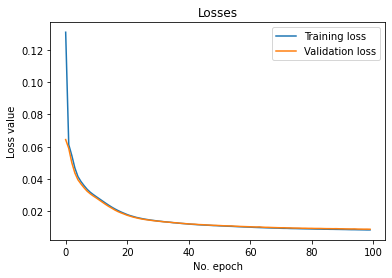

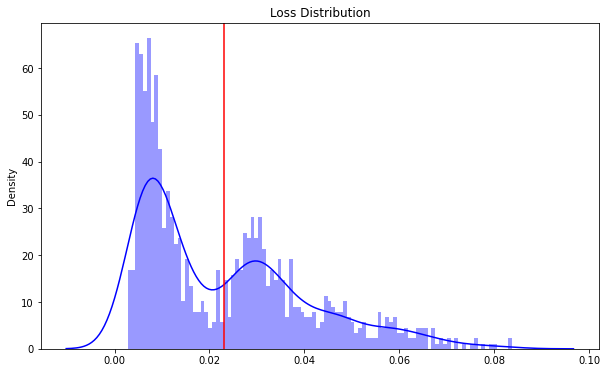

Model: 8 ,encoding_dim: 32 ,loss_fn: mean_squared_error ,optimizer: RMSprop ,augmented: True


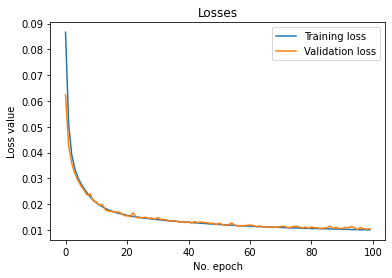

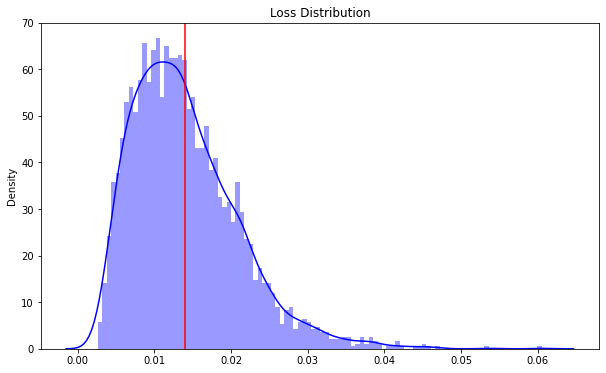

Model: 9 ,encoding_dim: 32 ,loss_fn: mean_squared_error ,optimizer: RMSprop ,augmented: False


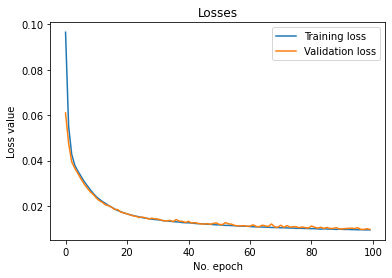

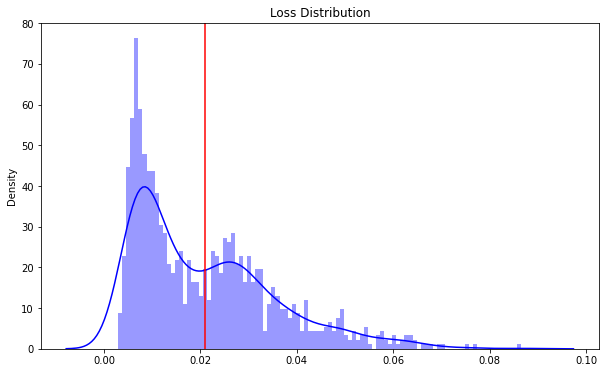

Model: 10 ,encoding_dim: 32 ,loss_fn: mean_squared_error ,optimizer: adadelta ,augmented: True


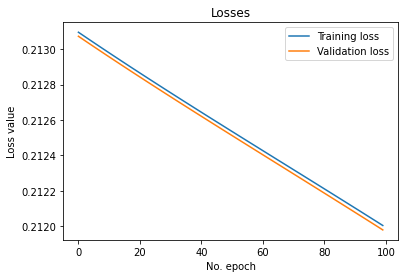

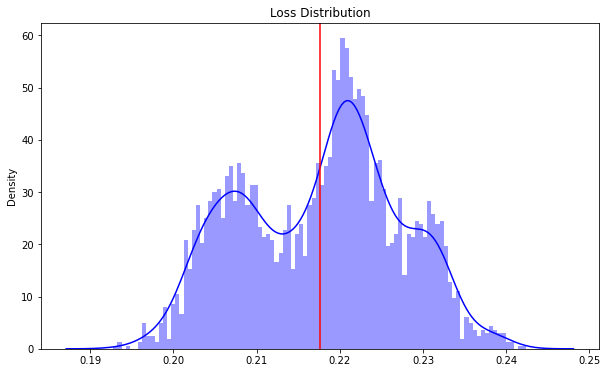

Model: 11 ,encoding_dim: 32 ,loss_fn: mean_squared_error ,optimizer: adadelta ,augmented: False


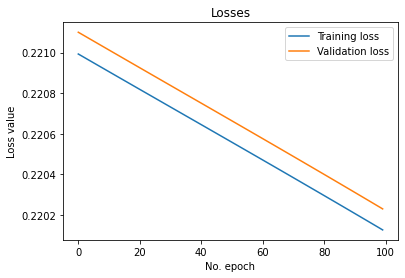

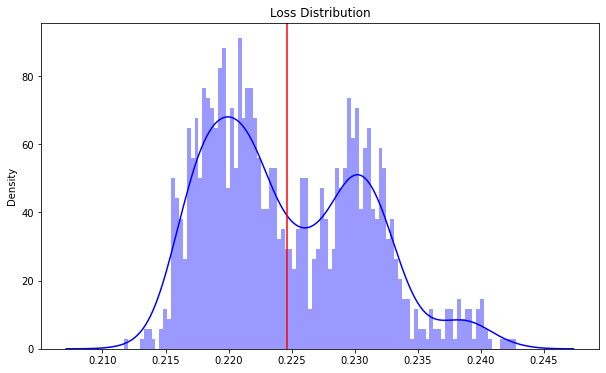

Model: 12 ,encoding_dim: 32 ,loss_fn: binary_crossentropy ,optimizer: adam ,augmented: True


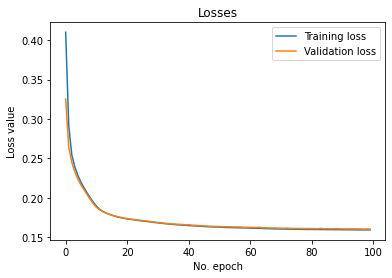

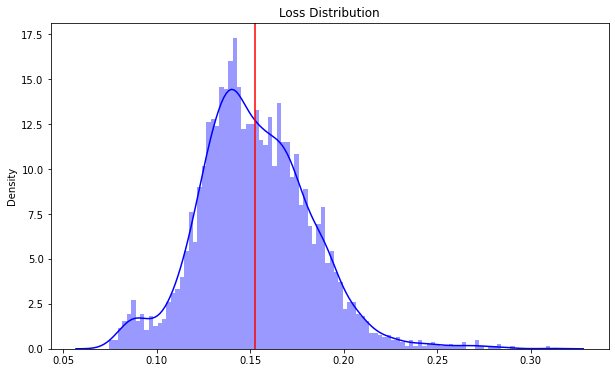

Model: 13 ,encoding_dim: 32 ,loss_fn: binary_crossentropy ,optimizer: adam ,augmented: False


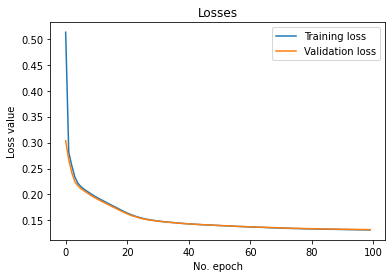

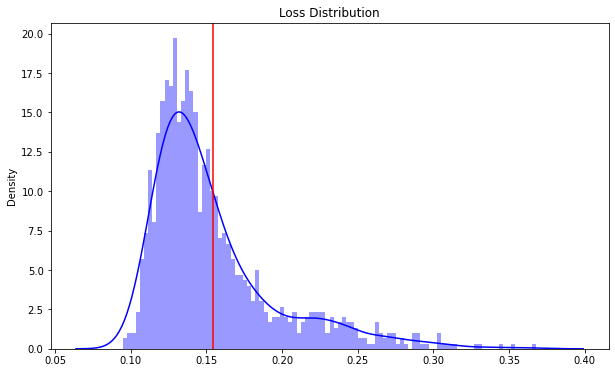

Model: 14 ,encoding_dim: 32 ,loss_fn: binary_crossentropy ,optimizer: RMSprop ,augmented: True


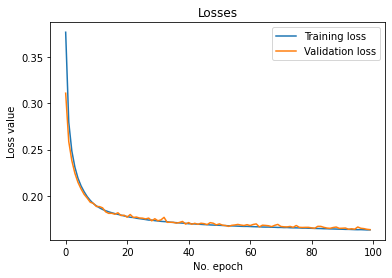

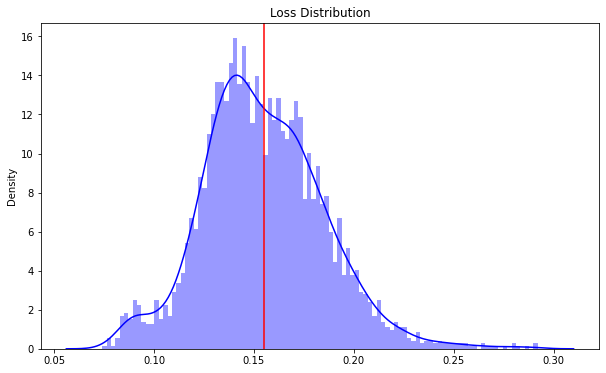

Model: 15 ,encoding_dim: 32 ,loss_fn: binary_crossentropy ,optimizer: RMSprop ,augmented: False


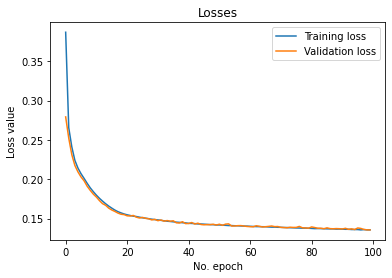

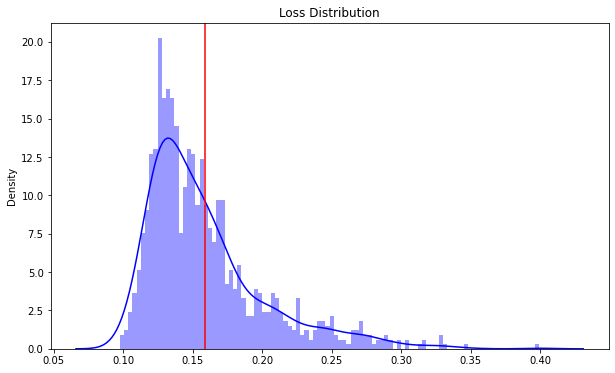

Model: 16 ,encoding_dim: 32 ,loss_fn: binary_crossentropy ,optimizer: adadelta ,augmented: True


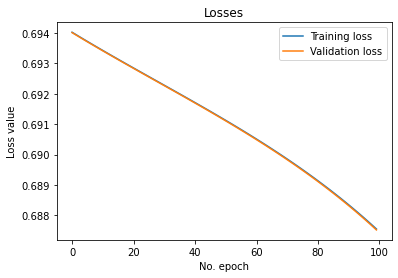

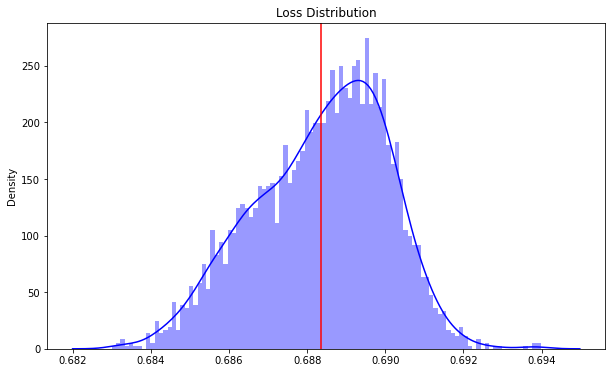

Model: 17 ,encoding_dim: 32 ,loss_fn: binary_crossentropy ,optimizer: adadelta ,augmented: False


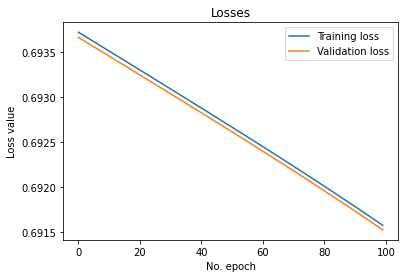

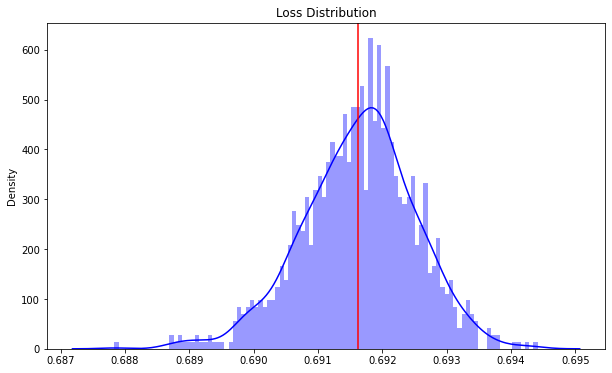

Model: 18 ,encoding_dim: 64 ,loss_fn: mean_absolute_error ,optimizer: adam ,augmented: True


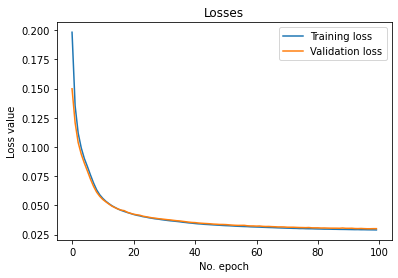

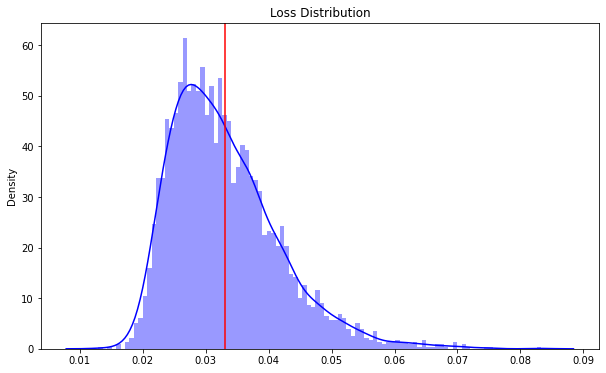

Model: 19 ,encoding_dim: 64 ,loss_fn: mean_absolute_error ,optimizer: adam ,augmented: False


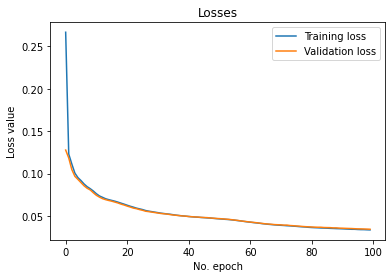

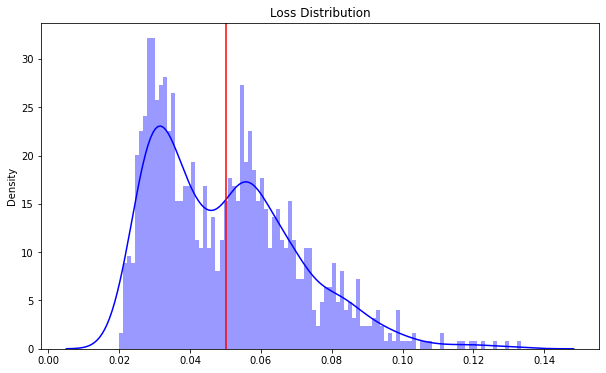

Model: 20 ,encoding_dim: 64 ,loss_fn: mean_absolute_error ,optimizer: RMSprop ,augmented: True


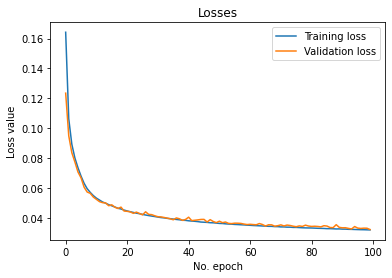

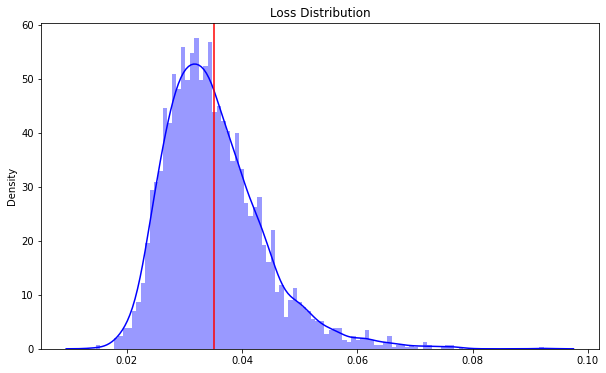

Model: 21 ,encoding_dim: 64 ,loss_fn: mean_absolute_error ,optimizer: RMSprop ,augmented: False


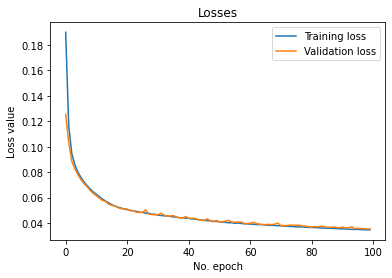

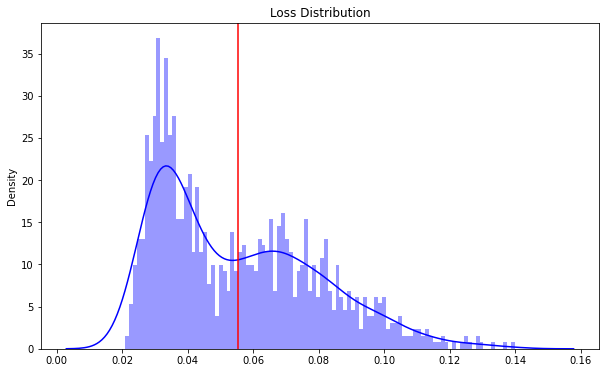

Model: 22 ,encoding_dim: 64 ,loss_fn: mean_absolute_error ,optimizer: adadelta ,augmented: True


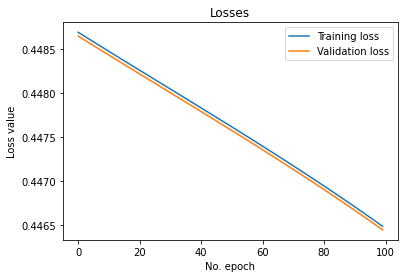

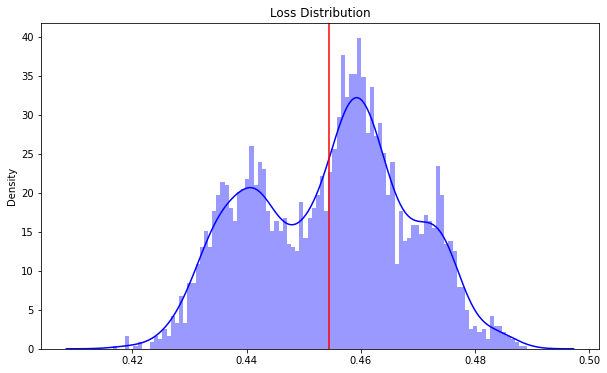

Model: 23 ,encoding_dim: 64 ,loss_fn: mean_absolute_error ,optimizer: adadelta ,augmented: False


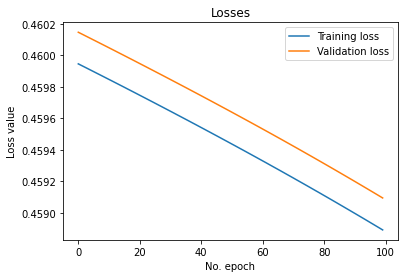

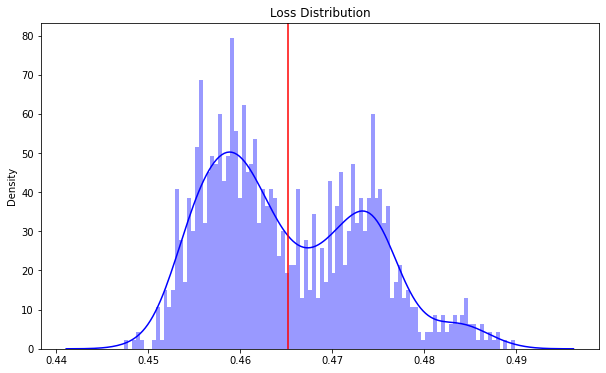

Model: 24 ,encoding_dim: 64 ,loss_fn: mean_squared_error ,optimizer: adam ,augmented: True


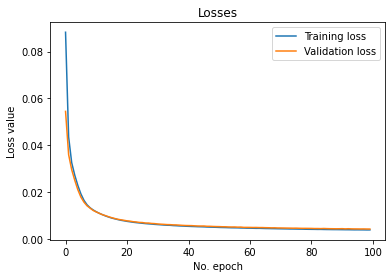

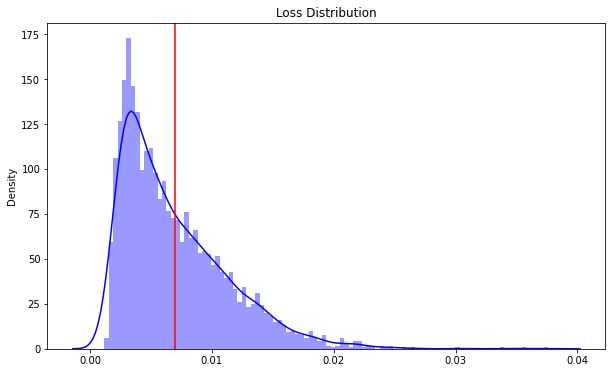

Model: 25 ,encoding_dim: 64 ,loss_fn: mean_squared_error ,optimizer: adam ,augmented: False


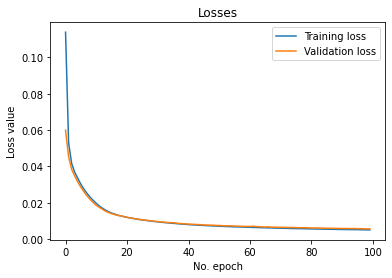

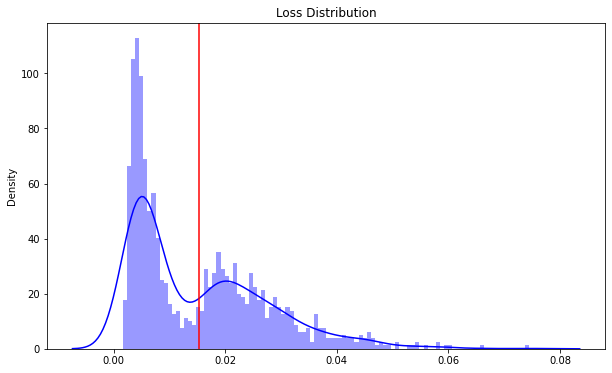

Model: 26 ,encoding_dim: 64 ,loss_fn: mean_squared_error ,optimizer: RMSprop ,augmented: True


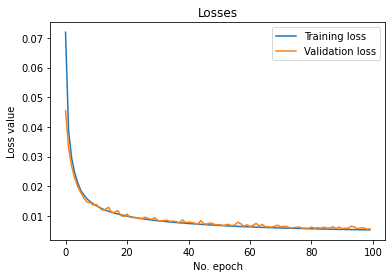

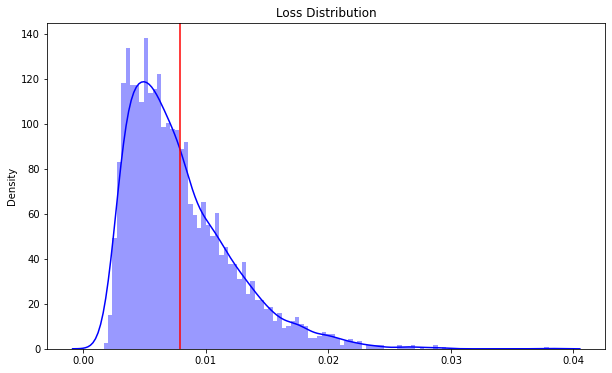

Model: 27 ,encoding_dim: 64 ,loss_fn: mean_squared_error ,optimizer: RMSprop ,augmented: False


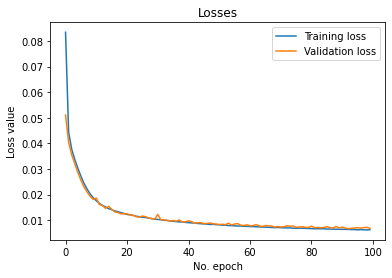

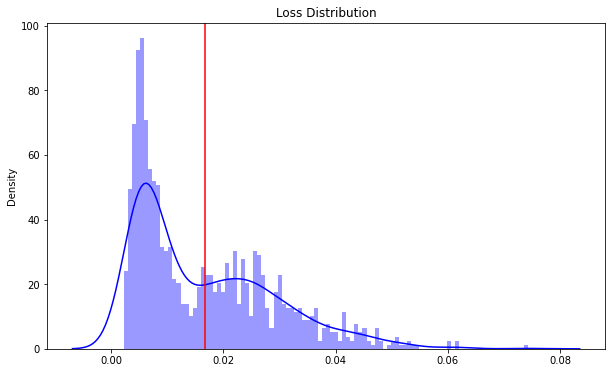

Model: 28 ,encoding_dim: 64 ,loss_fn: mean_squared_error ,optimizer: adadelta ,augmented: True


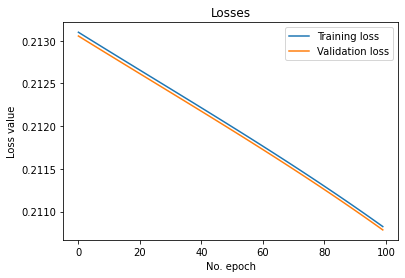

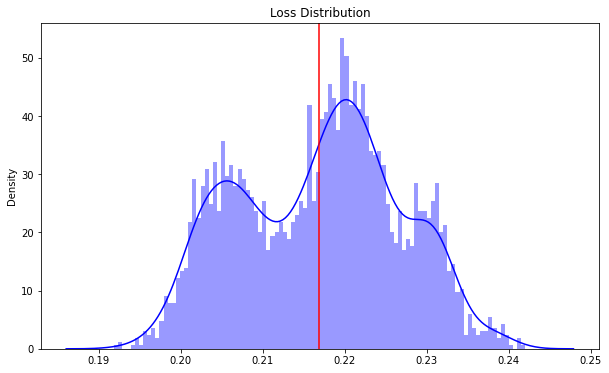

Model: 29 ,encoding_dim: 64 ,loss_fn: mean_squared_error ,optimizer: adadelta ,augmented: False


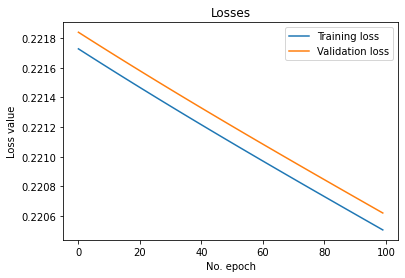

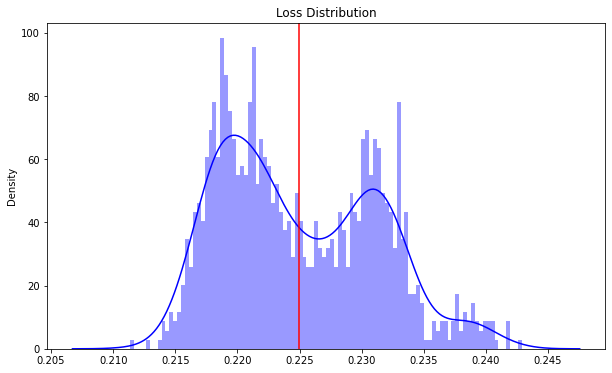

Model: 30 ,encoding_dim: 64 ,loss_fn: binary_crossentropy ,optimizer: adam ,augmented: True


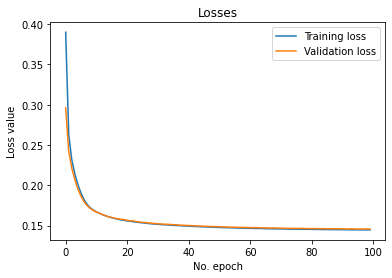

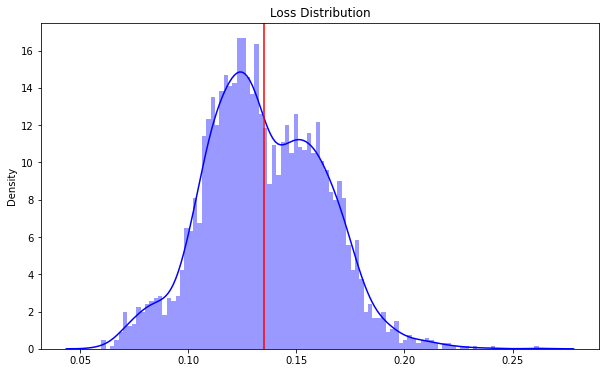

Model: 31 ,encoding_dim: 64 ,loss_fn: binary_crossentropy ,optimizer: adam ,augmented: False


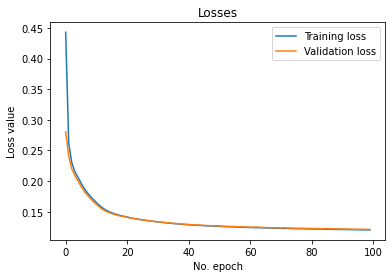

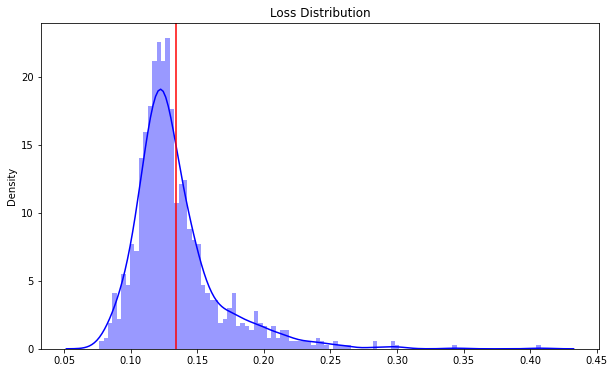

Model: 32 ,encoding_dim: 64 ,loss_fn: binary_crossentropy ,optimizer: RMSprop ,augmented: True


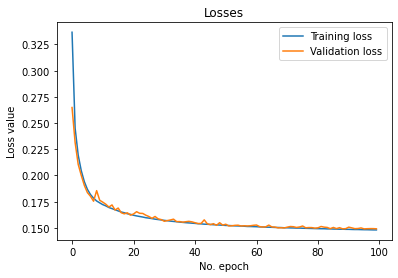

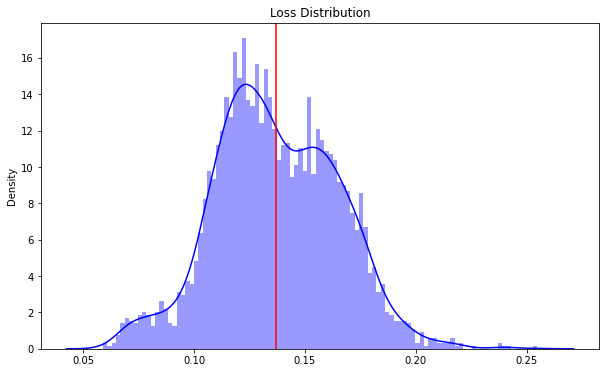

Model: 33 ,encoding_dim: 64 ,loss_fn: binary_crossentropy ,optimizer: RMSprop ,augmented: False


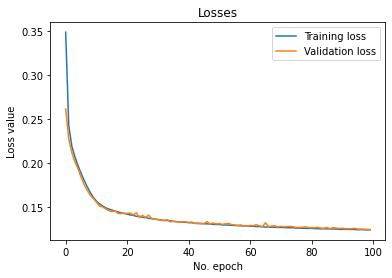

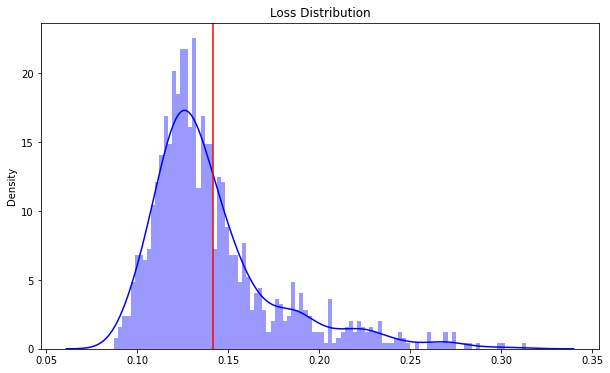

Model: 34 ,encoding_dim: 64 ,loss_fn: binary_crossentropy ,optimizer: adadelta ,augmented: True


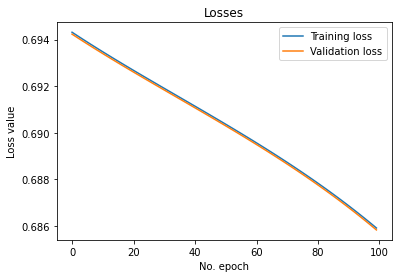

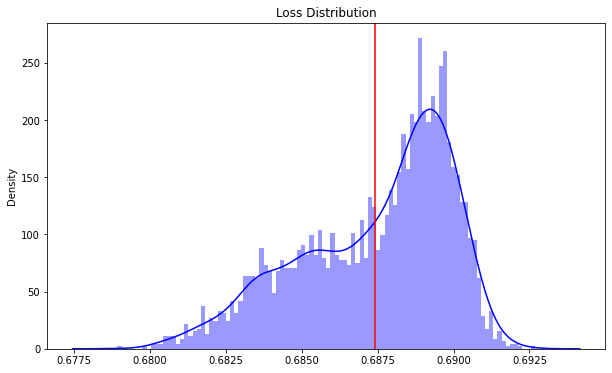

Model: 35 ,encoding_dim: 64 ,loss_fn: binary_crossentropy ,optimizer: adadelta ,augmented: False


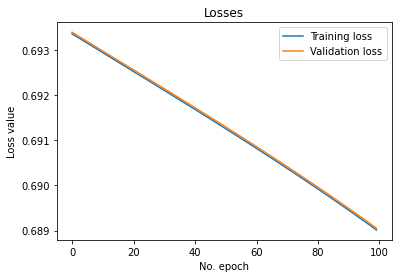

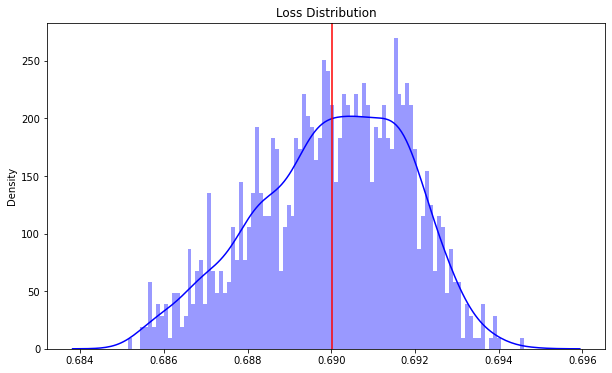

Model: 36 ,encoding_dim: 128 ,loss_fn: mean_absolute_error ,optimizer: adam ,augmented: True


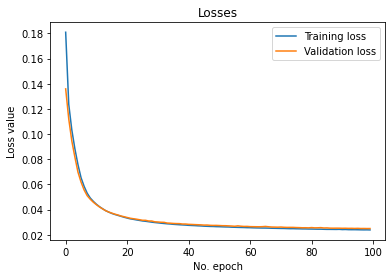

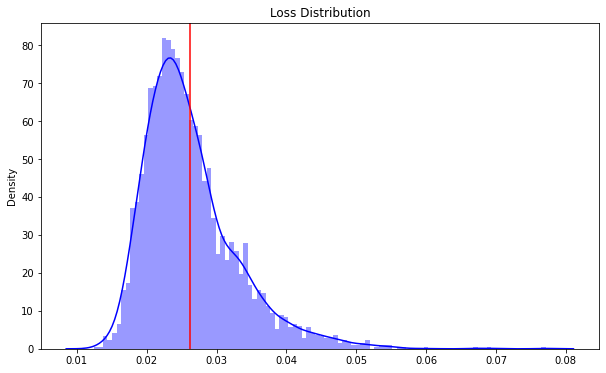

Model: 37 ,encoding_dim: 128 ,loss_fn: mean_absolute_error ,optimizer: adam ,augmented: False


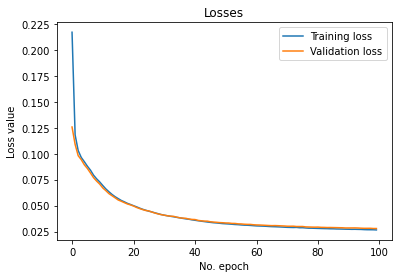

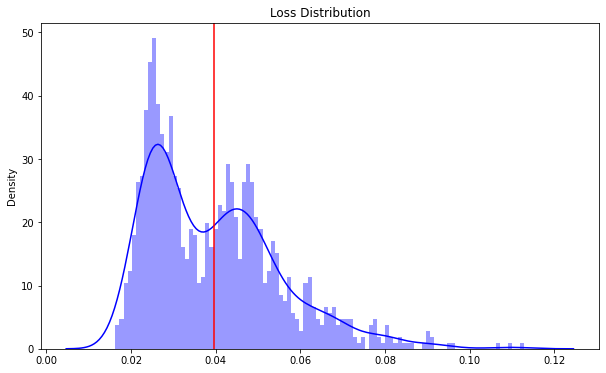

Model: 38 ,encoding_dim: 128 ,loss_fn: mean_absolute_error ,optimizer: RMSprop ,augmented: True


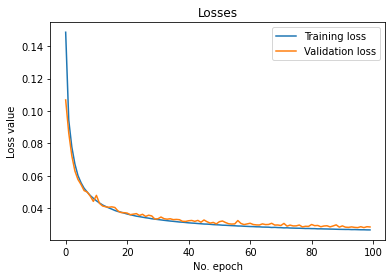

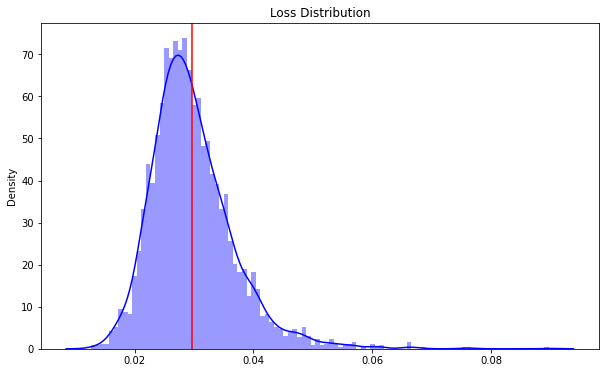

Model: 39 ,encoding_dim: 128 ,loss_fn: mean_absolute_error ,optimizer: RMSprop ,augmented: False


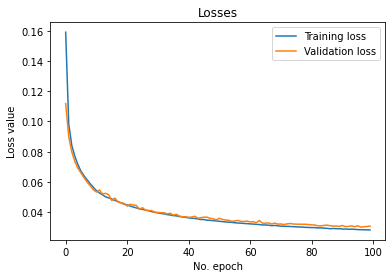

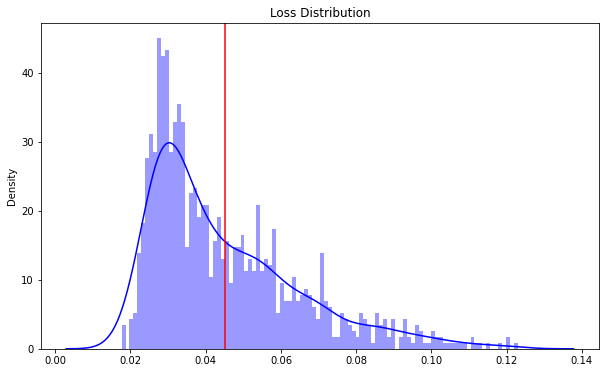

Model: 40 ,encoding_dim: 128 ,loss_fn: mean_absolute_error ,optimizer: adadelta ,augmented: True


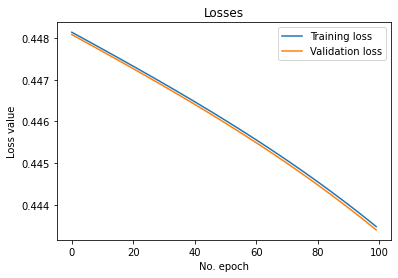

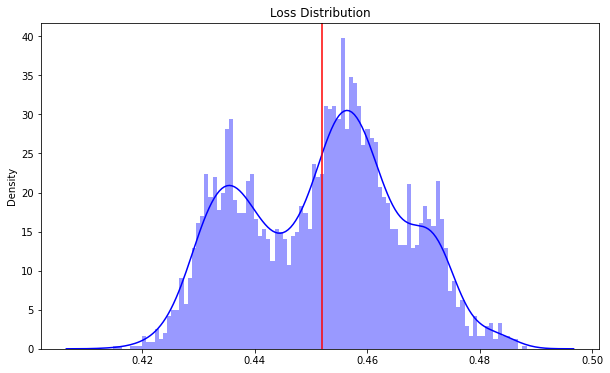

Model: 41 ,encoding_dim: 128 ,loss_fn: mean_absolute_error ,optimizer: adadelta ,augmented: False


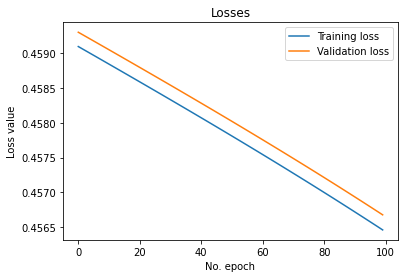

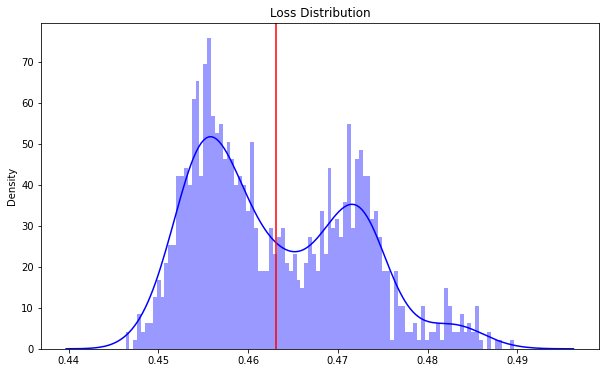

Model: 42 ,encoding_dim: 128 ,loss_fn: mean_squared_error ,optimizer: adam ,augmented: True


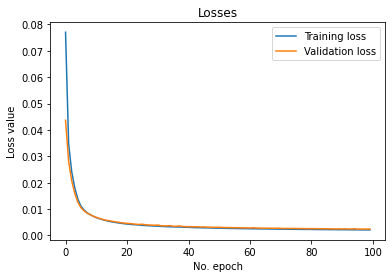

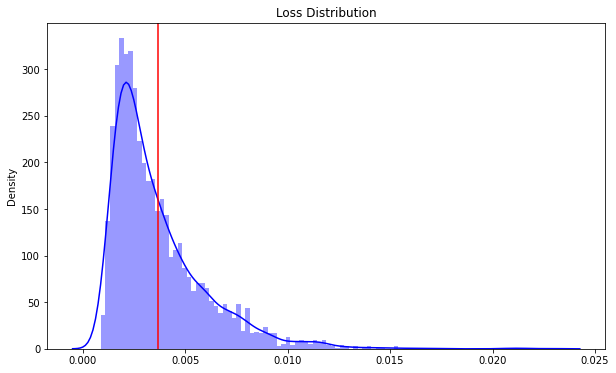

Model: 43 ,encoding_dim: 128 ,loss_fn: mean_squared_error ,optimizer: adam ,augmented: False


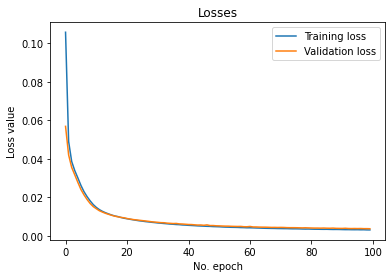

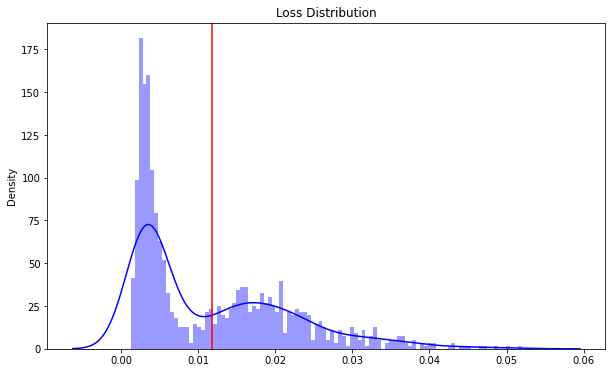

Model: 44 ,encoding_dim: 128 ,loss_fn: mean_squared_error ,optimizer: RMSprop ,augmented: True


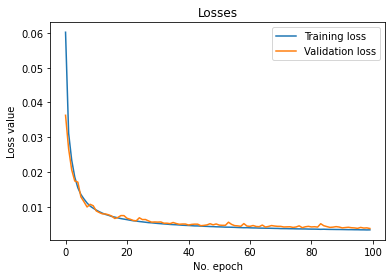

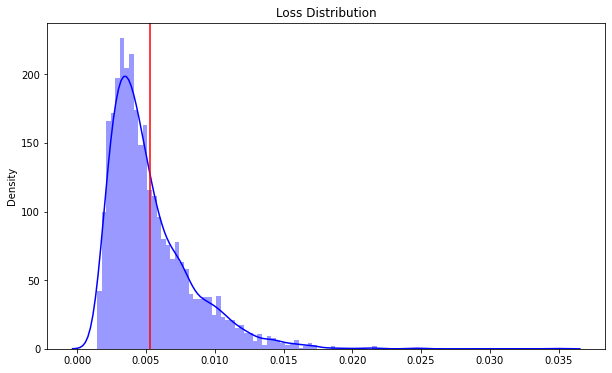

Model: 45 ,encoding_dim: 128 ,loss_fn: mean_squared_error ,optimizer: RMSprop ,augmented: False


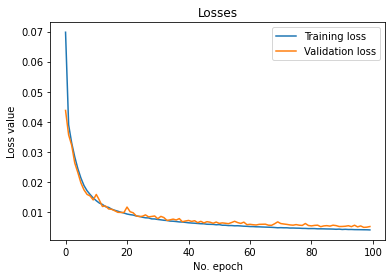

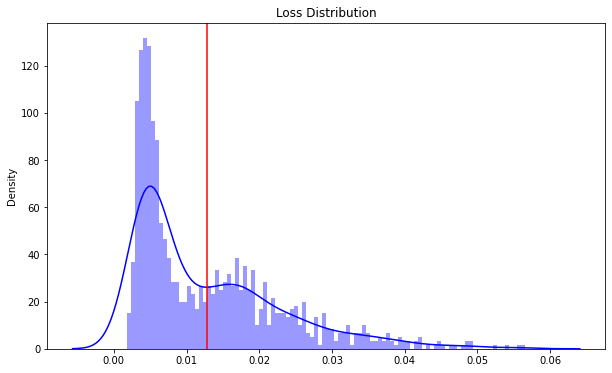

Model: 46 ,encoding_dim: 128 ,loss_fn: mean_squared_error ,optimizer: adadelta ,augmented: True


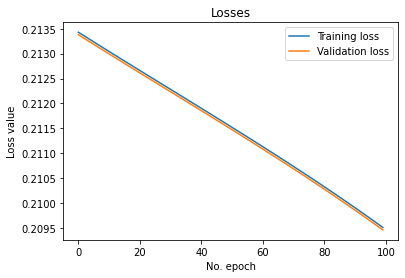

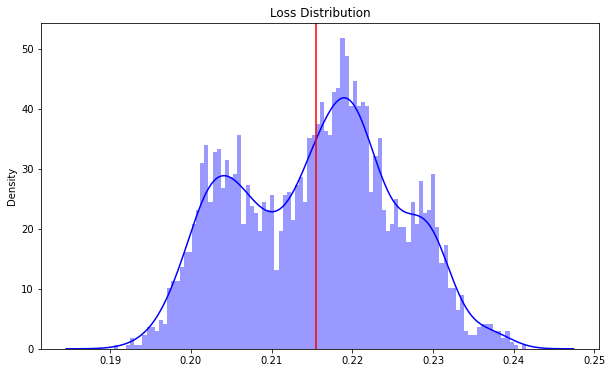

Model: 47 ,encoding_dim: 128 ,loss_fn: mean_squared_error ,optimizer: adadelta ,augmented: False


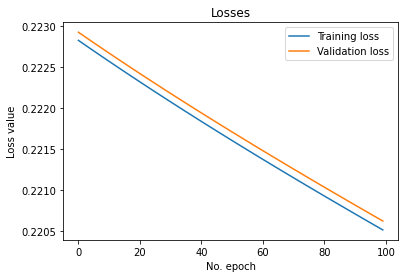

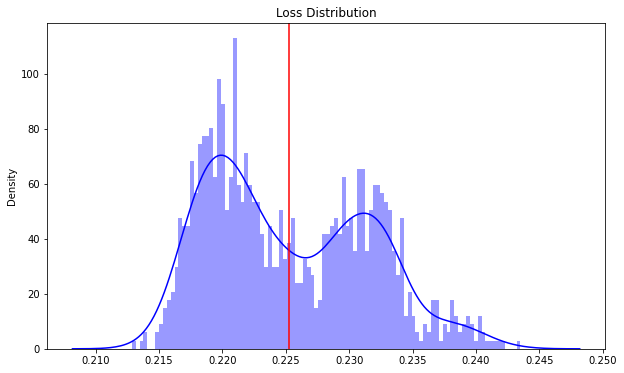

Model: 48 ,encoding_dim: 128 ,loss_fn: binary_crossentropy ,optimizer: adam ,augmented: True


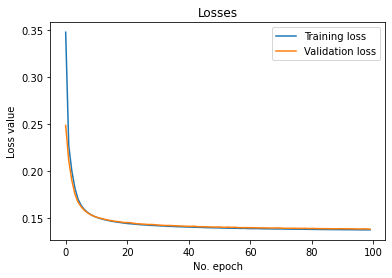

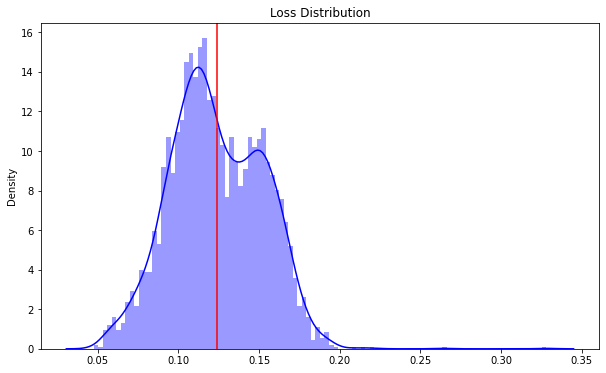

Model: 49 ,encoding_dim: 128 ,loss_fn: binary_crossentropy ,optimizer: adam ,augmented: False


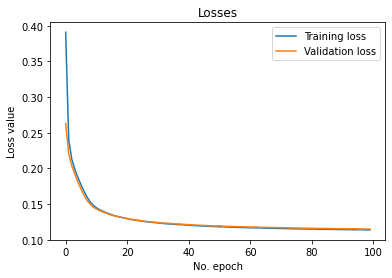

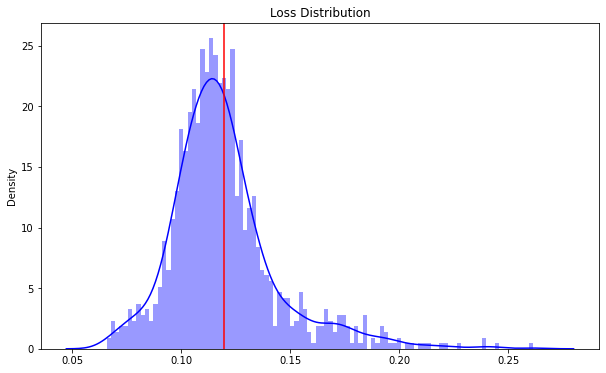

Model: 50 ,encoding_dim: 128 ,loss_fn: binary_crossentropy ,optimizer: RMSprop ,augmented: True


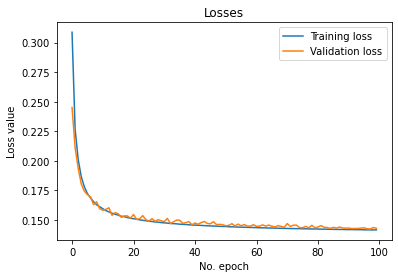

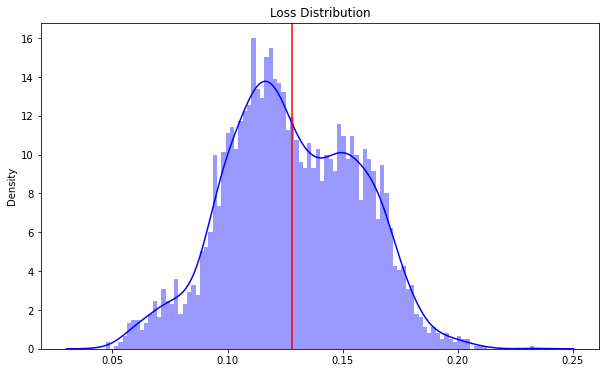

Model: 51 ,encoding_dim: 128 ,loss_fn: binary_crossentropy ,optimizer: RMSprop ,augmented: False


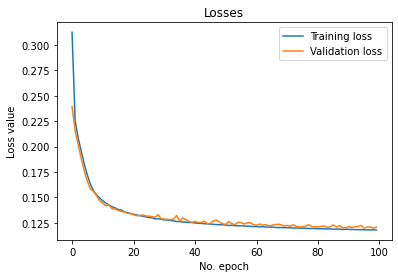

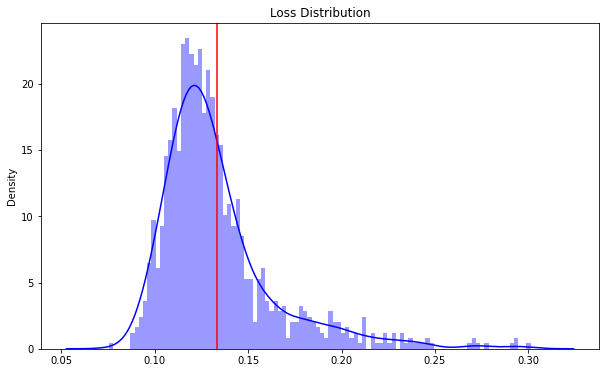

Model: 52 ,encoding_dim: 128 ,loss_fn: binary_crossentropy ,optimizer: adadelta ,augmented: True


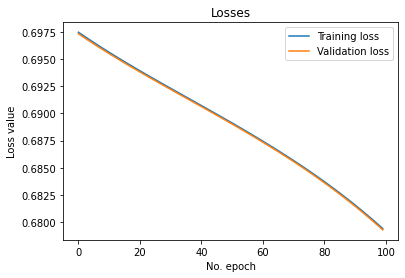

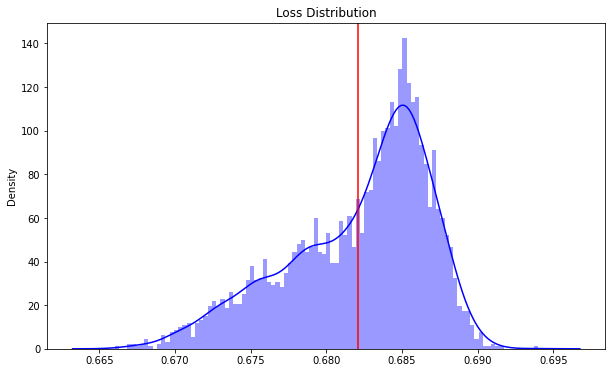

Model: 53 ,encoding_dim: 128 ,loss_fn: binary_crossentropy ,optimizer: adadelta ,augmented: False


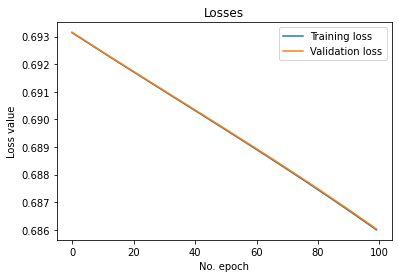

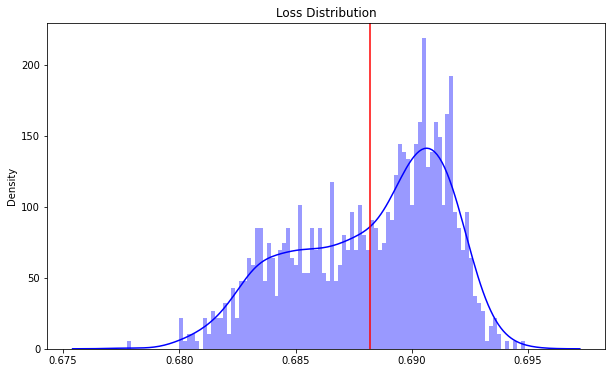

In [172]:
encoding_grid = [32,64,128]
loss_grid = ['mean_absolute_error','mean_squared_error', 'binary_crossentropy']
optimizer_grid = ['adam', 'RMSprop', 'adadelta']
augmented_grid = [True,False]

# To store gridsearch results
model_gridded = []
loss_dist_gridded = []
x_pred_arr_gridded = []
decoded_imgs_gridded = []

count = 0 # Keep track which models we are at

for e in encoding_grid:
    for l in loss_grid:
        for o in optimizer_grid:
            for a in augmented_grid:
                print("Model:", count, ",encoding_dim:", e, ",loss_fn:", l, \
                      ",optimizer:", o, ",augmented:", a)
                
                # Generate model
                model = train_model(e, l, o, a, 100) 
                history = model[0]
                autoencoder = model[1]
                loss_dist, x_pred_arr, decoded_imgs = generate_prediction(l, a)

                # Store results to array
                model_gridded.append(model) 
                loss_dist_gridded.append(loss_dist)
                x_pred_arr_gridded.append(x_pred_arr)
                decoded_imgs_gridded.append(decoded_imgs)
                
                # Plot train test validation and loss distribution
                plot_train_test_val(history)
                plot_losses(np.mean(loss_dist), loss_dist) # Set a temporary threshold
                count += 1

In [193]:
# Choosing the best model
best_idx = 25

model = model_gridded[best_idx]
autoencoder = model[1]
loss_dist = loss_dist_gridded[best_idx]
x_pred_arr = x_pred_arr_gridded[best_idx]
decoded_imgs = decoded_imgs_gridded[best_idx]

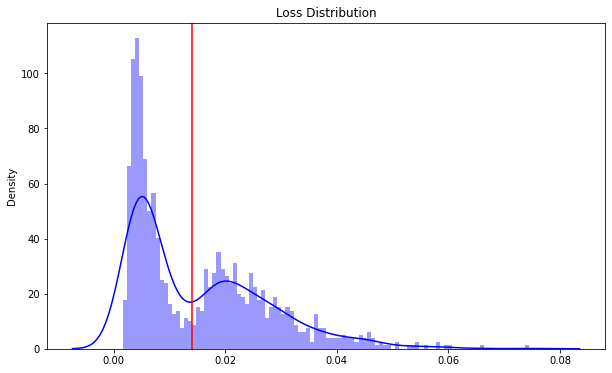

In [197]:
threshold = 0.014
plot_losses(threshold, loss_dist) # Set a permenant threshold

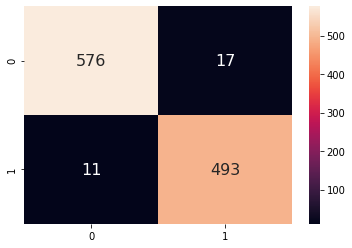

In [198]:
augmented = False
plot_cm(threshold,loss_dist, augmented)

## Comparison of prediction and original images

This section plots 2 row of 10 digits. The top row is the original image, and the bottom row is the reconstructed image from our autoencoder.

In [199]:
def compare_pred_actual(actual_arr, pred_arr):
    '''
    This function allows us to compare the actual image and the image generated by our autoencoder
    Input:
        1. Array of actual images
        2. Array of decoded images
    Output:
        1. Plot of images, top row representing actual image, bottom row representing generated images
    '''
    n = 10  # Display 10 digits
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # display original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(actual_arr[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(pred_arr[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

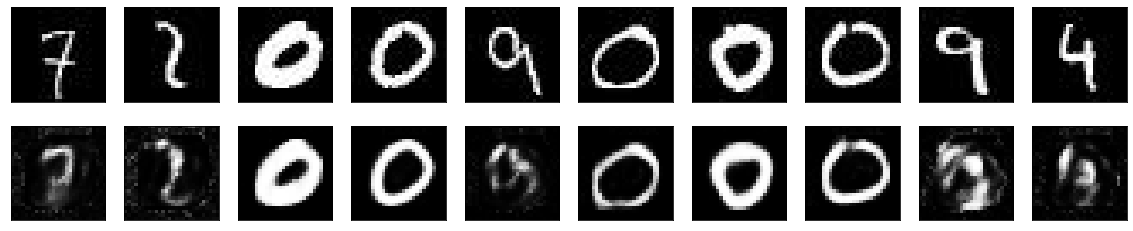

In [200]:
compare_pred_actual(x_pred_arr, decoded_imgs)

## Generating file for submission

In [201]:
def generate_submission(autoencoder, threshold):
    '''
    This method takes in a trained autoencoder and a valid threshold and generate files for Kaggle submision.
    Most of the code in this function are adapted from the above sections.
    Input:
        1. Trained autoencoder
        2. Pre-determined threshold
    Output:
        1. CSV file stored automatically at the root path
    '''

    # Pre-process the original data
    x_sub = copy.deepcopy(df_pred)
    x_sub_arr = np.array(x_sub)

    x_sub_arr = x_sub_arr.astype('float32') / 255. # Normalize
    x_sub_arr = x_sub_arr.reshape((len(x_sub_arr), np.prod(x_sub_arr.shape[1:]))) # Reshape

    # Autoencode the original data
    decoded_imgs = autoencoder.predict(x_sub_arr)

    # Generate losses. Using MSE since it was the best candidate
    mse = tf.keras.losses.MeanSquaredError()

    loss_dist = []
    for i in range(len(x_sub_arr)):
        loss_dist.append(mse(x_sub_arr[i], decoded_imgs[i]).numpy())

    # Split into normal and anomaly using threshold
    result = []

    for i in range(len(loss_dist)):
        if loss_dist[i] >= threshold: # This threshold has been pre-determined above
            result.append(1)
        else: # belongs to 0
            result.append(0)

    # Save prediction into CSV
    testcase = pd.DataFrame({
        "id": list(range(len(result))),
        "target": result
    })
    testcase.to_csv(root_path + "A0171412U_pred_keras.csv", index=False)

In [202]:
generate_submission(autoencoder, threshold)

# MODEL 2: Autoencoder with Convolutions
Below is an attempt to improve the above model using convolutions. Convolutions and more layers allow us to train a model that can recognise images better.

A 3 hidden-layer encoder and decoder is used, with maxpooling to reduce size of data, yet keeping crucial information. Upsampling layer is used to double the size of data during decoding.

In [154]:
# Define model architecture
input_img = Input(shape=(28, 28, 1)) 

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x) # Sigmoid since 2 classes

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer = 'adam', loss='mean_squared_error')

In [155]:
# Prepare input data
x_train = np.array(df_train.iloc[:,1:]) # Change to array
x_train = x_train.astype('float32') / 255. # Normalize
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1)) # Reshape 

In [156]:
# Start model training
history = autoencoder.fit(x_train, x_train,
                epochs=100,
                batch_size=128,
                shuffle=True,
                validation_split=0.2)

Epoch 1/100
34/34 [==============================] - 0s 13ms/step - loss: 0.1385 - val_loss: 0.0820
Epoch 2/100
34/34 [==============================] - 0s 8ms/step - loss: 0.0599 - val_loss: 0.0374
Epoch 3/100
34/34 [==============================] - 0s 7ms/step - loss: 0.0311 - val_loss: 0.0250
Epoch 4/100
34/34 [==============================] - 0s 7ms/step - loss: 0.0212 - val_loss: 0.0235
Epoch 5/100
34/34 [==============================] - 0s 7ms/step - loss: 0.0168 - val_loss: 0.0152
Epoch 6/100
34/34 [==============================] - 0s 7ms/step - loss: 0.0143 - val_loss: 0.0133
Epoch 7/100
34/34 [==============================] - 0s 7ms/step - loss: 0.0132 - val_loss: 0.0134
Epoch 8/100
34/34 [==============================] - 0s 7ms/step - loss: 0.0125 - val_loss: 0.0117
Epoch 9/100
34/34 [==============================] - 0s 7ms/step - loss: 0.0116 - val_loss: 0.0114
Epoch 10/100
34/34 [==============================] - 0s 7ms/step - loss: 0.0111 - val_loss: 0.0107
Epoch 11

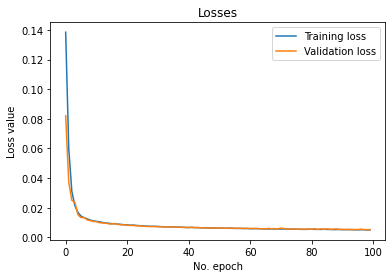

In [157]:
plot_train_test_val(history)

In [158]:
# Generate autoencoded images
x_pred = copy.deepcopy(df_test).iloc[:,1:]
x_pred_arr = np.array(x_pred) # Convert to numpy array
x_pred_arr = x_pred_arr.astype('float32') / 255. # Normalize
x_pred_arr = np.reshape(x_pred_arr, (len(x_pred_arr), 28, 28, 1)) # Reshape 

decoded_imgs = autoencoder.predict(x_pred_arr)

In [159]:
# Generate loss distribution
mse = tf.keras.losses.MeanSquaredError()

loss_dist = []
for i in range(len(x_pred_arr)):
    loss_dist.append(mse(x_pred_arr[i], decoded_imgs[i]).numpy())

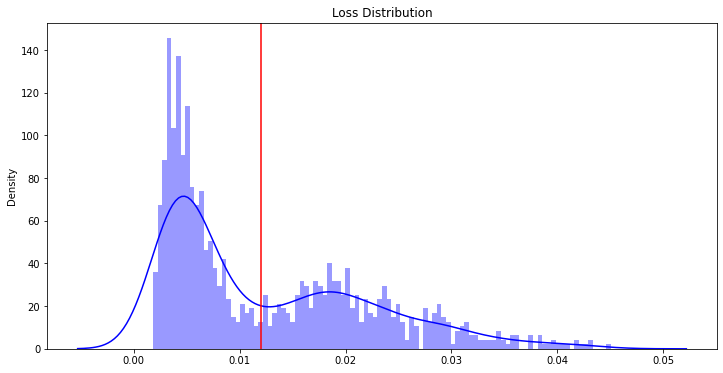

In [163]:
# Plot loss distribution
threshold = 0.012
plt.figure(figsize=(12,6))
plt.title('Loss Distribution')
sns.distplot(loss_dist,bins=100,kde=True, color='blue')
plt.axvline(threshold, 0.0, 10, color='r')

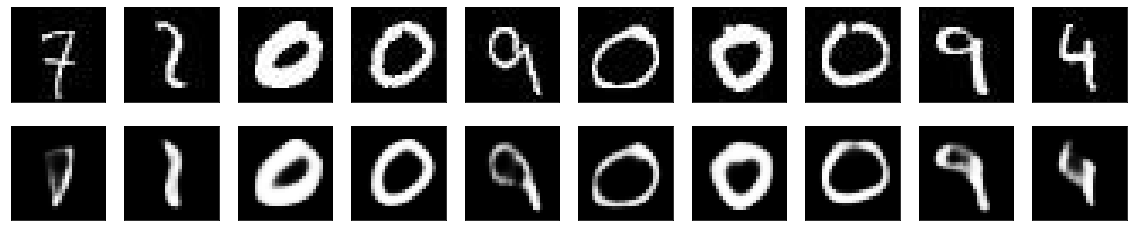

In [161]:
compare_pred_actual(x_pred_arr, decoded_imgs)

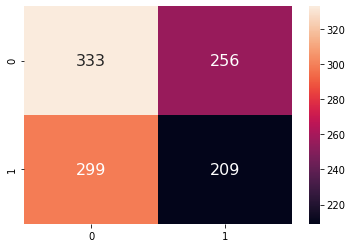

In [164]:
plot_cm(threshold, loss_dist, True)